### 1. Data source: SoC EIS LFP dataset

For this notebook I use the public dataset:

> Mustafa, Hamza; Bourelly, Carmine; Vitelli, Michele; Milano, Fillippo; Molinara, Mario; Ferrigno, Luigi (2024),  
> **“SoC Estimation on Li-ion Batteries: A New EIS-based Dataset for data-driven applications”**,  
> Mendeley Data, V2, doi: 10.17632/cb887gkmxw.2.  
> Available at: https://data.mendeley.com/datasets/cb887gkmxw/2  
> License: **CC BY 4.0**

Dataset highlights:

- 11 cylindrical **LFP** cells (B01–B11).
- EIS at 20 SoC levels: 100%, 95%, 90%, 85%, 80%, 75%, 70%, 65%, 60%, 55%, 50%, 45%, 40%, 35%, 30%, 25%, 20%, 15%, 10%, 5%.
- Two discharge cycles per cell, same frequency grid from 0.01 Hz to 1000 Hz (28 frequencies).

Folder structure (after downloading the dataset into `../data/soc_eis_lfp/`):

- One folder per cell: `B01`, `B02`, ..., `B11`.
- Inside each `Bxx` folder:
  - `EIS Measurement/` — subfolders with the actual EIS CSV files.
  - `Capacity Measurement/` — capacity test CSV (not used in this first notebook).


### 2. Load data & quick sanity checks.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_ROOT = Path("../data/soc_eis_lfp")

COLUMN_MAP = {
    "Frequency(Hz)": "frequency_hz",
    "R(ohm)": "z_real_ohm",
    "X(ohm)": "z_imag_ohm",
    "T(deg C)": "temperature_c",
}

def load_soc_eis(data_root: Path) -> pd.DataFrame:
    records = []

    for batt in range(1, 12):  # B01 .. B11
        battery_id = f"B{batt:02d}"

        for test_name, cycle in [("Test_1", 1), ("Test_2", 2)]:
            hioki_dir = data_root / battery_id / "EIS measurements" / test_name / "Hioki"

            for csv_path in sorted(hioki_dir.glob("*.csv")):
                # Hk_IFR14500_SoC_100_03-07-2023_11-46.csv -> SoC = 100
                fname_parts = csv_path.stem.split("_")
                soc = int(fname_parts[3])

                df_raw = pd.read_csv(csv_path)
                df = df_raw[list(COLUMN_MAP.keys())].rename(columns=COLUMN_MAP)

                df["battery_id"] = battery_id
                df["cycle"] = cycle
                df["soc"] = soc

                records.append(df)

    full_df = pd.concat(records, ignore_index=True)
    return full_df

eis_df = load_soc_eis(DATA_ROOT)

# Quick sanity checks
print("Shape:", eis_df.shape)
print("Batteries:", eis_df["battery_id"].unique())
print("Cycles:", sorted(eis_df["cycle"].unique()))
print("Unique SOCs:", sorted(eis_df["soc"].unique()))
print("Freq min/max:", eis_df["frequency_hz"].min(), "→", eis_df["frequency_hz"].max())
print("Temp min/max:", eis_df["temperature_c"].min(), "→", eis_df["temperature_c"].max())

eis_df.head()


Shape: (12320, 7)
Batteries: ['B01' 'B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B08' 'B09' 'B10' 'B11']
Cycles: [np.int64(1), np.int64(2)]
Unique SOCs: [np.int64(5), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95), np.int64(100)]
Freq min/max: 0.01 → 1000.0
Temp min/max: 20 → 20


,frequency_hz,z_real_ohm,z_imag_ohm,temperature_c,battery_id,cycle,soc
0,0.01,0.227844,-0.313990,20,B01,1,100
1,0.02,0.182858,-0.197273,20,B01,1,100
2,0.03,0.163270,-0.160068,20,B01,1,100
3,0.05,0.138709,-0.113159,20,B01,1,100
4,0.08,0.121685,-0.082724,20,B01,1,100


In [2]:
# Basic overview
eis_df.describe(include="all").round(3)


,frequency_hz,z_real_ohm,z_imag_ohm,temperature_c,battery_id,cycle,soc
count,12320.000,12320.000,12320.000,12320.0,12320,12320.0,12320.000
unique,NaN,NaN,NaN,NaN,11,NaN,NaN
top,NaN,NaN,NaN,NaN,B01,NaN,NaN
freq,NaN,NaN,NaN,NaN,1120,NaN,NaN
mean,117.360,0.078,-0.015,20.0,NaN,1.5,52.500
std,246.764,0.025,0.031,0.0,NaN,0.5,28.833
min,0.010,0.042,-1.329,20.0,NaN,1.0,5.000
25%,0.275,0.061,-0.015,20.0,NaN,1.0,28.750
50%,6.500,0.072,-0.007,20.0,NaN,1.5,52.500
75%,85.750,0.089,-0.006,20.0,NaN,2.0,76.250


In [3]:
# 1) Missing values
eis_df.isna().sum()


frequency_hz     0
z_real_ohm       0
z_imag_ohm       0
temperature_c    0
battery_id       0
cycle            0
soc              0
dtype: int64

In [4]:
# 2) Duplicate rows
eis_df.duplicated().sum()


np.int64(0)

In [5]:
# 3) Per-spectrum point count
pts_per_spectrum = (
    eis_df
    .groupby(["battery_id", "cycle", "soc"])["frequency_hz"]
    .count()
)

print("Unique point counts per spectrum:", pts_per_spectrum.unique())
pts_per_spectrum.describe()


Unique point counts per spectrum: [28]


count    440.0
mean      28.0
std        0.0
min       28.0
25%       28.0
50%       28.0
75%       28.0
max       28.0
Name: frequency_hz, dtype: float64

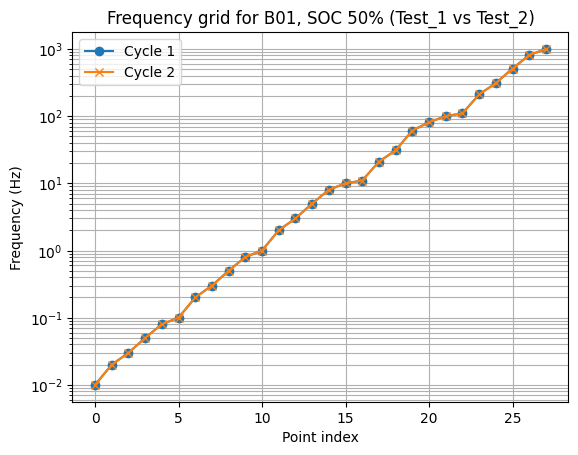

In [6]:
import matplotlib.pyplot as plt

spec1 = (
    eis_df
    .query("battery_id == 'B01' and cycle == 1 and soc == 50")
    .sort_values("frequency_hz")
    .reset_index(drop=True)
)

spec2 = (
    eis_df
    .query("battery_id == 'B01' and cycle == 2 and soc == 50")
    .sort_values("frequency_hz")
    .reset_index(drop=True)
)

plt.figure()
plt.plot(spec1.index, spec1["frequency_hz"], marker="o", label="Cycle 1")
plt.plot(spec2.index, spec2["frequency_hz"], marker="x", label="Cycle 2")
plt.yscale("log")
plt.xlabel("Point index")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency grid for B01, SOC 50% (Test_1 vs Test_2)")
plt.grid(True, which="both")
plt.legend()
plt.show()


### 2. Cycle QC and averaging

Each cell and SOC has two EIS measurements (Test_1 and Test_2).  
Here I first check how consistent these repeats are, then average them to  
get one “denoised” spectrum per (battery_id, SOC) for the rest of the notebook.


count    220.000
mean       0.026
std        0.040
min        0.003
25%        0.009
50%        0.011
75%        0.025
max        0.331
Name: rel_diff, dtype: float64


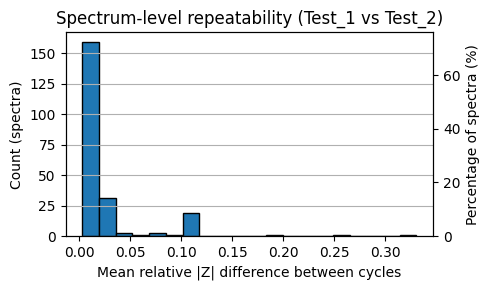

In [7]:
# Use magnitude for a simple repeatability check
if "z_mag_ohm" not in eis_df.columns:
    eis_df["z_mag_ohm"] = np.sqrt(eis_df["z_real_ohm"]**2 + eis_df["z_imag_ohm"]**2)

pivot = eis_df.pivot_table(
    index=["battery_id", "soc", "frequency_hz"],
    columns="cycle",
    values="z_mag_ohm"
).dropna()

pivot["rel_diff"] = (pivot[1] - pivot[2]).abs() / pivot[[1, 2]].mean(axis=1)

# collapse over frequency -> one number per (battery_id, soc)
spec_rel_diff = (
    pivot
    .groupby(["battery_id", "soc"])["rel_diff"]
    .mean()
)

print(spec_rel_diff.describe().round(3))

total = len(spec_rel_diff)

fig, ax1 = plt.subplots(figsize=(5, 3))

# Histogram in counts
ax1.hist(spec_rel_diff, bins=20, edgecolor="black")
ax1.set_xlabel("Mean relative |Z| difference between cycles")
ax1.set_ylabel("Count (spectra)")
ax1.set_title("Spectrum-level repeatability (Test_1 vs Test_2)")
ax1.grid(True, axis="y")

# Second y-axis: percentage
ax2 = ax1.twinx()
ymin, ymax = ax1.get_ylim()
ax2.set_ylim(ymin / total * 100, ymax / total * 100)
ax2.set_ylabel("Percentage of spectra (%)")

plt.tight_layout()
plt.show()


The relative |Z| difference between Test_1 and Test_2 is mostly very small  
(median ≈ 1.1%, 75% ≈ 2.5%), with a few larger outliers up to ≈ 33%.  
In this notebook I keep all spectra and simply average the two cycles per  
(battery_id, SOC), which is reasonable given the overall good repeatability.  
In a stricter setting one could drop spectra where the mean relative difference  
between cycles exceeds, for example, 20%.


In [8]:
# Average over cycles -> one spectrum per (battery_id, soc, frequency_hz)
eis_df_avg = (
    eis_df
    .groupby(["battery_id", "soc", "frequency_hz"], as_index=False)
    .agg({
        "z_real_ohm": "mean",
        "z_imag_ohm": "mean",
        "temperature_c": "mean",
    })
)

print("Averaged EIS table shape:", eis_df_avg.shape)

# From here on, work with the averaged data
eis_df = eis_df_avg.copy()


Averaged EIS table shape: (6160, 6)


### 3. EIS visualisation vs SOC

#### 3.1 Add magnitude and phase


In [9]:
eis_df["z_mag_ohm"] = np.sqrt(eis_df["z_real_ohm"]**2 + eis_df["z_imag_ohm"]**2)
eis_df["z_phase_deg"] = np.degrees(np.arctan2(eis_df["z_imag_ohm"], eis_df["z_real_ohm"]))


#### 3.2 Nyquist plots at different SOCs (one battery, one cycle)


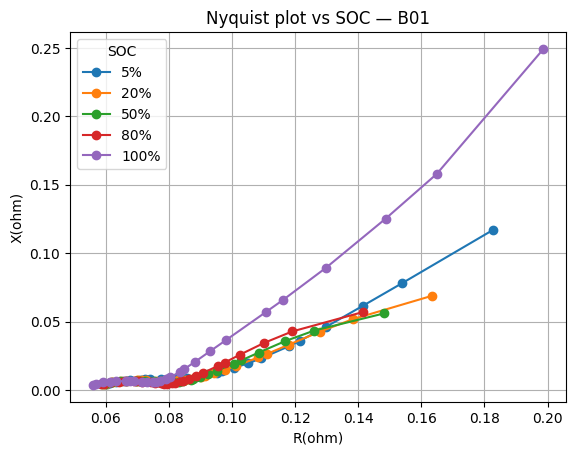

In [10]:
battery_id_to_plot = "B01"

sub = eis_df[
    (eis_df["battery_id"] == battery_id_to_plot)
].copy()

soc_levels_to_plot = [5, 20, 50, 80, 100]
soc_levels_available = sorted(sub["soc"].unique())
soc_levels_to_plot = [s for s in soc_levels_to_plot if s in soc_levels_available]

plt.figure()

for soc in soc_levels_to_plot:
    g = sub[sub["soc"] == soc].sort_values("frequency_hz")
    plt.plot(g["z_real_ohm"], -g["z_imag_ohm"], marker="o", label=f"{soc}%")

plt.xlabel("R(ohm)")
plt.ylabel("X(ohm)")
plt.title(f"Nyquist plot vs SOC — {battery_id_to_plot}")
plt.legend(title="SOC")
plt.grid(True)
plt.show()


#### 3.3 Bode plots (magnitude & phase vs frequency)


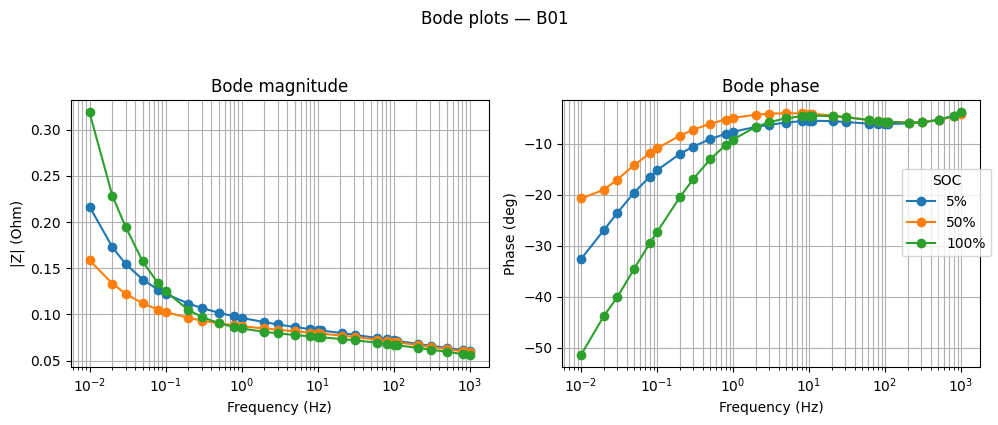

In [11]:
from matplotlib.ticker import ScalarFormatter

battery_id_to_plot = "B01"

sub = eis_df[
    (eis_df["battery_id"] == battery_id_to_plot)
].copy()

soc_levels_to_plot = [5, 50, 100]
soc_levels_available = sorted(sub["soc"].unique())
soc_levels_to_plot = [s for s in soc_levels_to_plot if s in soc_levels_available]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True)

ax_mag, ax_phase = axes

# --- Magnitude ---
for soc in soc_levels_to_plot:
    g = sub[sub["soc"] == soc].sort_values("frequency_hz")
    ax_mag.semilogx(g["frequency_hz"], g["z_mag_ohm"], marker="o", label=f"{soc}%")

ax_mag.set_xlabel("Frequency (Hz)")
ax_mag.set_ylabel("|Z| (Ohm)")
ax_mag.set_title("Bode magnitude")
ax_mag.grid(True, which="both")

sf = ScalarFormatter()
sf.set_scientific(False)
sf.set_useOffset(False)
ax_mag.yaxis.set_major_formatter(sf)

# --- Phase ---
for soc in soc_levels_to_plot:
    g = sub[sub["soc"] == soc].sort_values("frequency_hz")
    ax_phase.semilogx(g["frequency_hz"], g["z_phase_deg"], marker="o", label=f"{soc}%")

ax_phase.set_xlabel("Frequency (Hz)")
ax_phase.set_ylabel("Phase (deg)")
ax_phase.set_title("Bode phase")
ax_phase.grid(True, which="both")

# One shared legend
handles, labels = ax_mag.get_legend_handles_labels()
fig.legend(handles, labels, title="SOC", loc="center right", ncol=1)

fig.suptitle(f"Bode plots — {battery_id_to_plot}", y=1.05)
plt.tight_layout()
plt.show()


### 4. Feature engineering: simple impedance fingerprints

Goal: compress each full EIS spectrum into a small feature vector, one row per  
**(battery_id, SOC)**, that we can later feed to a simple ML model.

In this section I will:
- Create one feature row per (battery_id, soc).
- Use basic summary features (min/max/mean) of |Z| and phase.
- Sample |Z| and phase at a few fixed frequencies.

**Why these engineered features?**

The goal is to capture simple, physically meaningful aspects of the EIS curve
without fitting a full equivalent circuit model:

- `zreal_lowfreq` / `zreal_highfreq`  
  - Roughly “low-frequency / polarization resistance” vs “high-frequency /
    ohmic resistance”.  
  - These shift with SOC as the cell’s effective resistance changes.

- `zmag_mean`, `zmag_max`  
  - Overall “size” of the impedance arc and its peak.  
  - Higher values usually mean higher resistance / lower conductivity.

- `phase_min`, `phase_max`  
  - Range of capacitive / diffusive behaviour across frequency.  
  - SOC changes how strongly capacitive or resistive the cell looks.

- `zmag_{f}Hz`, `phase_{f}Hz` at 0.01, 0.1, 1, 10, 100, 1000 Hz  
  - These frequencies are chosen as simple, log-spaced points across the
    available 0.01–1000 Hz band.  
  - Together they sample the low-, mid-, and high-frequency parts of the
    spectrum, giving a compact but informative “fingerprint” for SOC
    estimation.


#### 4.1 Choose target frequencies from the measured grid

I sample |Z| and phase at a few log-spaced frequencies that exist in the data,
to capture the overall shape of the spectrum in a compact way.


In [12]:
freqs = np.sort(eis_df["frequency_hz"].unique())

print("Measured frequency grid:")
for i, f in enumerate(freqs):
    print(f"{i:2d}: {f:g} Hz")


Measured frequency grid:
 0: 0.01 Hz
 1: 0.02 Hz
 2: 0.03 Hz
 3: 0.05 Hz
 4: 0.08 Hz
 5: 0.1 Hz
 6: 0.2 Hz
 7: 0.3 Hz
 8: 0.5 Hz
 9: 0.8 Hz
10: 1 Hz
11: 2 Hz
12: 3 Hz
13: 5 Hz
14: 8 Hz
15: 10 Hz
16: 11 Hz
17: 21 Hz
18: 31 Hz
19: 61 Hz
20: 81 Hz
21: 100 Hz
22: 110 Hz
23: 210 Hz
24: 310 Hz
25: 510 Hz
26: 810 Hz
27: 1000 Hz


In [13]:
# Frequencies (within the 0.01–1000 Hz range) where we sample |Z| and phase
target_freqs = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
print("Target frequencies:")
for i, f in enumerate(target_freqs):
    print(f"{i:2d}: {f:g} Hz")


Target frequencies:
 0: 0.01 Hz
 1: 0.1 Hz
 2: 1 Hz
 3: 10 Hz
 4: 100 Hz
 5: 1000 Hz


#### 4.2 Build one feature vector per (battery_id, SOC)

For each averaged EIS spectrum I create a single feature row.  
I keep a few global summary statistics (extremes and averages), and I take
|Z| and phase directly at a set of fixed frequencies
(0.01, 0.1, 1, 10, 100, 1000 Hz).


In [14]:
feature_rows = []

for (battery_id, soc), g in eis_df.groupby(["battery_id", "soc"]):
    g = g.sort_values("frequency_hz").copy()

    # Global stats
    z_real = g["z_real_ohm"].to_numpy()
    z_mag = g["z_mag_ohm"].to_numpy()
    phase = g["z_phase_deg"].to_numpy()

    row = {
        "battery_id": battery_id,
        "soc": soc,
        "zreal_lowfreq": z_real[0],
        "zreal_highfreq": z_real[-1],
        "zmag_mean": z_mag.mean(),
        "zmag_max": z_mag.max(),
        "phase_min": phase.min(),
        "phase_max": phase.max(),
    }

    # Take |Z| and phase at exact target frequencies
    g_idx = g.set_index("frequency_hz")

    for f in target_freqs:
        freq_label = str(f).replace(".", "p")
        row[f"zmag_{freq_label}Hz"] = g_idx.loc[f, "z_mag_ohm"]
        row[f"phase_{freq_label}Hz"] = g_idx.loc[f, "z_phase_deg"]

    feature_rows.append(row)

feat_df = pd.DataFrame(feature_rows)
feat_df.head()


,battery_id,soc,zreal_lowfreq,zreal_highfreq,zmag_mean,zmag_max,phase_min,phase_max,zmag_0p01Hz,phase_0p01Hz,zmag_0p1Hz,phase_0p1Hz,zmag_1p0Hz,phase_1p0Hz,zmag_10p0Hz,phase_10p0Hz,zmag_100p0Hz,phase_100p0Hz,zmag_1000p0Hz,phase_1000p0Hz
0,B01,5,0.182653,0.060269,0.097467,0.216863,-32.621081,-4.004392,0.216863,-32.621081,0.122336,-15.181986,0.096208,-7.636961,0.083010,-5.468509,0.071766,-6.121537,0.060417,-4.004392
1,B01,10,0.170783,0.059821,0.092930,0.187566,-24.422087,-3.960382,0.187566,-24.422087,0.115161,-13.161971,0.092719,-6.811176,0.081175,-4.923678,0.071196,-5.845588,0.059965,-3.960382
2,B01,15,0.166635,0.059541,0.091769,0.180553,-22.644222,-3.972768,0.180553,-22.644222,0.113091,-12.632649,0.091900,-6.489224,0.080937,-4.856404,0.070999,-5.846668,0.059685,-3.972768
3,B01,20,0.163275,0.059271,0.090735,0.177173,-22.845436,-3.991457,0.177173,-22.845436,0.110929,-12.400498,0.090892,-6.178033,0.080575,-4.715034,0.070769,-5.840951,0.059415,-3.991457
4,B01,25,0.160309,0.059097,0.089930,0.172943,-22.036235,-4.016717,0.172943,-22.036235,0.109430,-12.100670,0.090236,-5.955735,0.080347,-4.614360,0.070625,-5.832845,0.059243,-4.016717


#### 4.3 Visualise key feature distributions

Before modelling, I check a few key feature distributions to see:

- that values look reasonable,
- and that there is some spread across samples (so the model has signal to learn from).


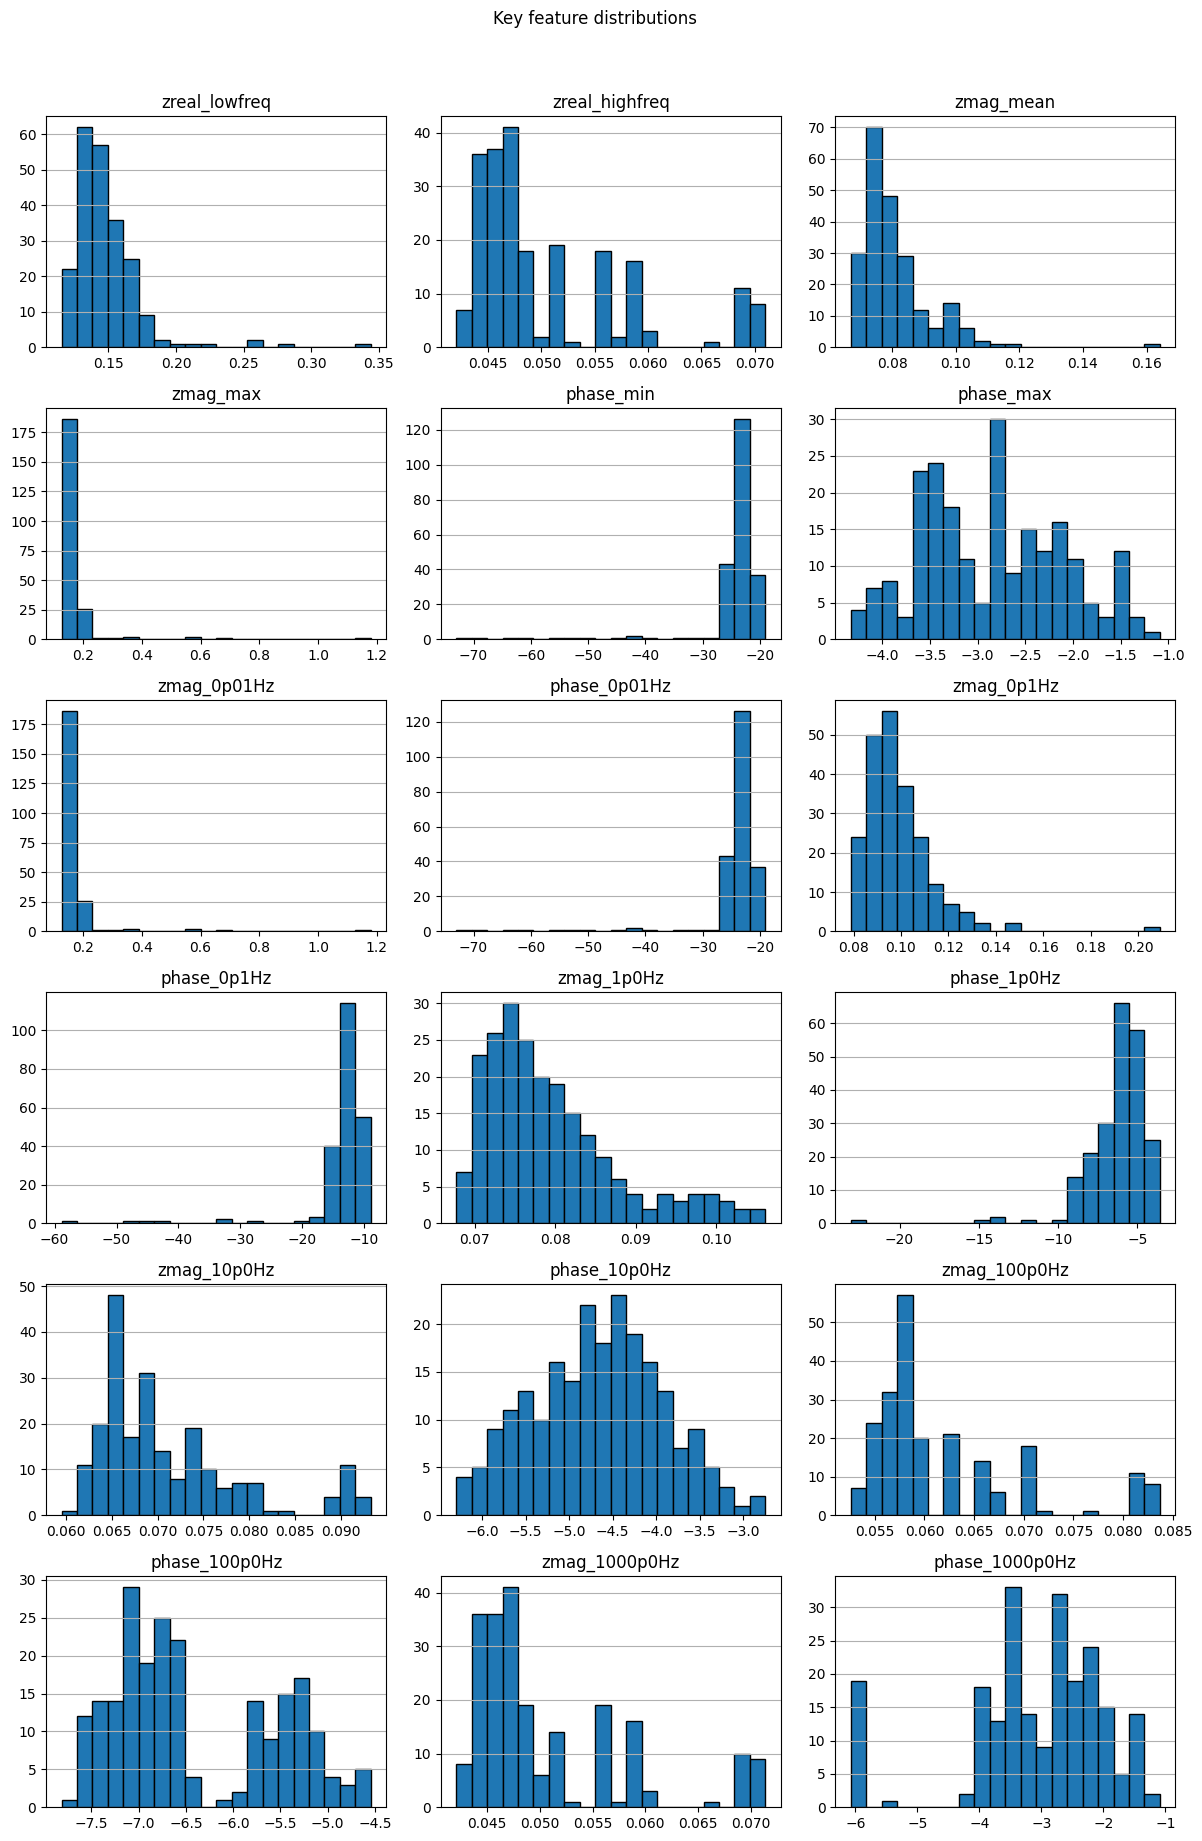

In [15]:
key_features = feat_df.columns.values[2:].tolist() # not battery_id and soc

n = len(key_features)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axes = axes.flatten()

for ax, feat in zip(axes, key_features):
    ax.hist(feat_df[feat], bins=20, edgecolor="black")
    ax.set_title(feat)
    ax.grid(True, axis="y")

# Hide any unused subplots
for ax in axes[len(key_features):]:
    ax.set_visible(False)

fig.suptitle("Key feature distributions", y=1.02)
plt.tight_layout()
plt.show()


#### 4.4 Correlation of engineered features with SOC

To keep things readable, I only look at how each engineered feature correlates
with **SOC** (rather than a full feature–feature heatmap).

I use **Spearman rank correlation** between SOC and all numeric features and
mark statistically significant correlations:

- `*`  : p < 0.05  
- `**` : p < 0.01  
- `***`: p < 0.001

This highlights which features are most informative for SOC and which ones are
largely redundant.


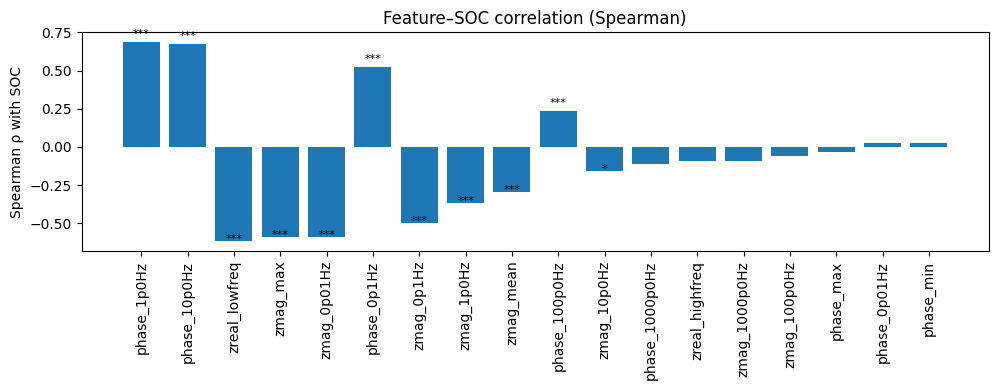

In [16]:
from scipy.stats import spearmanr

# Numeric features only (skip battery_id, cycle if they are non-numeric)
numeric_cols = feat_df.select_dtypes(include=[np.number]).columns.tolist()

# Spearman correlation and p-values
corr_matrix, p_matrix = spearmanr(feat_df[numeric_cols].values)
corr = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)
pvals = pd.DataFrame(p_matrix, index=numeric_cols, columns=numeric_cols)

rho_soc = corr["soc"].drop("soc")
p_soc = pvals["soc"].drop("soc")

# Sort by |rho|
order = rho_soc.abs().sort_values(ascending=False).index
rho_sorted = rho_soc[order]
p_sorted = p_soc[order]

x = np.arange(len(order))

plt.figure(figsize=(10, 4))
plt.bar(x, rho_sorted)
plt.xticks(x, order, rotation=90)
plt.ylabel("Spearman ρ with SOC")
plt.title("Feature–SOC correlation (Spearman)")

# Add stars for significance
for xi, (r, p) in enumerate(zip(rho_sorted, p_sorted)):
    if p < 0.001:
        star = "***"
    elif p < 0.01:
        star = "**"
    elif p < 0.05:
        star = "*"
    else:
        star = ""
    if star:
        plt.text(xi, r + 0.02 * np.sign(r), star,
                 ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

#### 4.5 SOC vs significantly correlated features (aggregated by SOC)

Scatter plots were noisy, so here I aggregate by SOC and plot, for each  
significant feature (p < 0.05):

- median value vs SOC (line),
- 25–75% range vs SOC (shaded band).

This makes monotonic trends much easier to see.


Significant features (p < 0.05): ['phase_1p0Hz', 'phase_10p0Hz', 'zreal_lowfreq', 'zmag_max', 'zmag_0p01Hz', 'phase_0p1Hz', 'zmag_0p1Hz', 'zmag_1p0Hz', 'zmag_mean', 'phase_100p0Hz', 'zmag_10p0Hz']


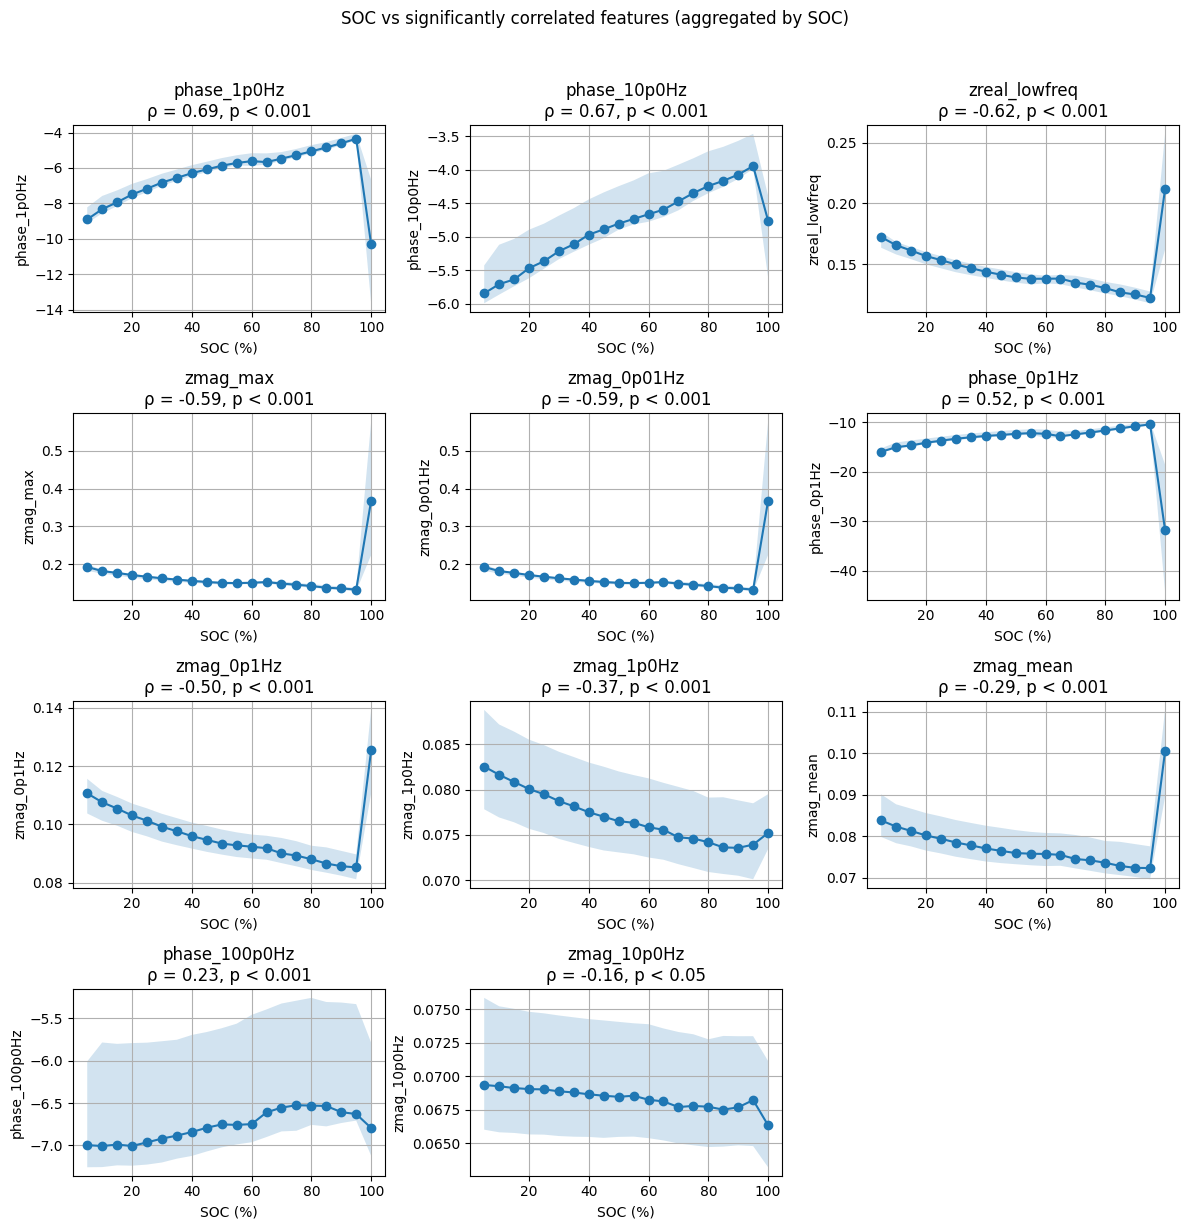

In [17]:
# Reuse `corr` and `pvals` from the Spearman step (section 3.4)
p_soc = pvals.loc["soc"]
corr_soc = corr.loc["soc"]

# Significant features: p < 0.05, excluding SOC itself
mask = (p_soc < 0.05) & (p_soc.index != "soc")
sig_feats = p_soc.index[mask].tolist()

# Sort by |rho| so the strongest ones come first
sig_feats_sorted = sorted(sig_feats, key=lambda f: abs(corr_soc[f]), reverse=True)
print("Significant features (p < 0.05):", sig_feats_sorted)

# Precompute SOC order
soc_levels = sorted(feat_df["soc"].unique())

n = len(sig_feats_sorted)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
axes = axes.flatten()

for ax, feat in zip(axes, sig_feats_sorted):
    # group by SOC for this feature
    grouped = feat_df.groupby("soc")[feat]

    med = grouped.median().reindex(soc_levels)
    q25 = grouped.quantile(0.25).reindex(soc_levels)
    q75 = grouped.quantile(0.75).reindex(soc_levels)

    ax.plot(soc_levels, med, marker="o")
    ax.fill_between(soc_levels, q25, q75, alpha=0.2)

    rho = corr_soc[feat]
    p = p_soc[feat]
    if p < 0.001:
        p_str = "p < 0.001"
    elif p < 0.01:
        p_str = "p < 0.01"
    else:
        p_str = "p < 0.05"

    ax.set_xlabel("SOC (%)")
    ax.set_ylabel(feat)
    ax.set_title(f"{feat}\nρ = {rho:.2f}, {p_str}")
    ax.grid(True)

# Hide unused axes
for ax in axes[len(sig_feats_sorted):]:
    ax.set_visible(False)

fig.suptitle("SOC vs significantly correlated features (aggregated by SOC)", y=1.02)
plt.tight_layout()
plt.show()


### 5. SOC prediction target & problem setup

#### 5.1 Define targets

Main target (regression):
- `soc` in %, e.g. 5–100.

Optional side target (bins):
- Coarse SOC bands (0–20, 20–40, 40–60, 60–80, 80–100%) for an easier
  “are we in the right band?” view.


In [18]:
# Regression target
y_reg = feat_df["soc"].to_numpy()

soc_bin_edges = [0, 20, 40, 60, 80, 101]  # last edge slightly above 100
feat_df["soc_bin"] = pd.cut(
    feat_df["soc"],
    bins=soc_bin_edges,
    labels=False,
    include_lowest=True,
    right=True,
)

feat_df["soc_bin"].value_counts().sort_index()


soc_bin
0    44
1    44
2    44
3    44
4    44
Name: count, dtype: int64

#### 5.2 Feature subsets: all vs significant

I compare two feature sets:

- **all**: all engineered numeric features except identifiers and targets
- **sig**: only features with significant Spearman correlation to SOC (p < 0.05)

Both will be evaluated inside the same nested GroupKFold CV.


In [19]:
y_bin = feat_df["soc_bin"].to_numpy()
groups = feat_df["battery_id"].to_numpy()

# --- Feature set: ALL ---
exclude_cols = ["battery_id", "soc", "soc_bin"]
feature_cols_all = [c for c in feat_df.columns if c not in exclude_cols]
X_all = feat_df[feature_cols_all].to_numpy()

# --- Feature set: SIG (Spearman p < 0.05 vs SOC) ---
rho_soc = corr.loc["soc"]
p_soc = pvals.loc["soc"]

mask_sig = (p_soc < 0.05) & (p_soc.index != "soc")
sig_features = p_soc.index[mask_sig].tolist()

# Keep only those that are in feature_cols_all
feature_cols_sig = [f for f in sig_features if f in feature_cols_all]
X_sig = feat_df[feature_cols_sig].to_numpy()

print("All features:", len(feature_cols_all))
print("Significant features:", len(feature_cols_sig))
print("Significant feature names:", feature_cols_sig)


All features: 18
Significant features: 11
Significant feature names: ['zreal_lowfreq', 'zmag_mean', 'zmag_max', 'zmag_0p01Hz', 'zmag_0p1Hz', 'phase_0p1Hz', 'zmag_1p0Hz', 'phase_1p0Hz', 'zmag_10p0Hz', 'phase_10p0Hz', 'phase_100p0Hz']


#### 5.4 Models and nested GroupKFold setup

I compare two models:

- **RandomForestRegressor** (non-linear, tree ensemble)
- **ElasticNet** (linear model with L1/L2 regularisation in a scaled pipeline)

Nested grouped CV:

- **Outer**: GroupKFold(n_splits=5) on `battery_id`
  - ~80% of cells for training, ~20% for testing in each fold.
- **Inner**: GroupKFold(n_splits=3) on the outer-train cells
  - used only for hyperparameter tuning (MAE as objective).


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV

outer_cv = GroupKFold(n_splits=5)
inner_cv = GroupKFold(n_splits=3)

# RandomForest (no scaling needed)
rf_estimator = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
)
rf_param_grid = {
    "n_estimators": [150, 300],
    "max_depth": [None, 15],
}

# ElasticNet in a scaled pipeline (no pure ridge, more iterations)
enet_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000, random_state=42)),
])

enet_param_grid = {
    "model__alpha": [0.1, 1.0, 10.0],     # a bit more regularisation
    "model__l1_ratio": [0.5, 1.0],        # elastic net / lasso, no ridge
}

models = {
    "rf": (rf_estimator, rf_param_grid),
    "enet": (enet_pipeline, enet_param_grid),
}

feature_sets = {
    "all": (X_all, feature_cols_all),
    "sig": (X_sig, feature_cols_sig),
}

#### 5.5 Nested GroupKFold CV: run and collect metrics

For each outer fold (5 folds):

- Use only the outer-train cells in a 3-fold GroupKFold inner CV to tune
  hyperparameters for each (feature set, model) combination.
- Refit the best model on all outer-train data.
- Evaluate on the outer-test cells:

  - MAE (mean absolute error) in SOC %
  - RMSE (root mean squared error) in SOC %
  - SOC-bin accuracy (using the coarse bins defined earlier)

I also record how many samples and batteries are in train/test per fold.


In [21]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

results = []
fold_summaries = []

n_outer = outer_cv.get_n_splits(X_all, y_reg, groups)
n_fs = len(feature_sets)
n_models = len(models)
total_steps = n_outer * n_fs * n_models

step = 0
pbar = tqdm(total=total_steps, desc="Nested CV", leave=True)

for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_all, y_reg, groups)):
    y_train = y_reg[train_idx]
    y_test = y_reg[test_idx]
    y_train_bin = y_bin[train_idx]
    y_test_bin = y_bin[test_idx]
    groups_train = groups[train_idx]
    groups_test = groups[test_idx]

    train_batts = np.unique(groups_train)
    test_batts = np.unique(groups_test)

    fold_summaries.append({
        "fold": fold_idx,
        "n_train_samples": len(train_idx),
        "n_test_samples": len(test_idx),
        "n_train_batteries": len(train_batts),
        "n_test_batteries": len(test_batts),
        "train_batteries": ", ".join(train_batts),
        "test_batteries": ", ".join(test_batts),
    })

    for fs_name, (X_fs, cols_fs) in feature_sets.items():
        X_train_fs = X_fs[train_idx]
        X_test_fs = X_fs[test_idx]

        for model_name, (estimator, param_grid) in models.items():
            step += 1
            pbar.set_description(
                f"[Step {step}/{total_steps}] fold={fold_idx}, fs={fs_name}, model={model_name}"
            )
            pbar.update(1)

            search = GridSearchCV(
                estimator=estimator,
                param_grid=param_grid,
                cv=inner_cv,
                scoring="neg_mean_absolute_error",
                n_jobs=-1,
            )

            search.fit(X_train_fs, y_train, groups=groups_train)
            best_model = search.best_estimator_

            y_pred = best_model.predict(X_test_fs)
            mae = mean_absolute_error(y_test, y_pred)
            rmse_val = root_mean_squared_error(y_test, y_pred)

            # SOC-bin accuracy (evaluation only)
            y_pred_bin = pd.cut(
                pd.Series(y_pred),          # ensure we get a Series
                bins=soc_bin_edges,
                labels=False,
                include_lowest=True,
                right=True,
            ).to_numpy()

            bin_acc = (y_pred_bin == y_test_bin).mean()

            # Optional: short print per combo (comment out if too verbose)
            print(
                f"Fold {fold_idx}, fs={fs_name}, model={model_name} | "
                f"MAE={mae:.2f}, RMSE={rmse_val:.2f}, bin_acc={bin_acc:.2%}, "
                f"best={search.best_params_}"
            )

            results.append({
                "fold": fold_idx,
                "feature_set": fs_name,
                "model": model_name,
                "mae": mae,
                "rmse": rmse_val,
                "bin_acc": bin_acc,
                "best_params": search.best_params_,
            })

pbar.close()

fold_summary_df = pd.DataFrame(fold_summaries)
results_df = pd.DataFrame(results)

fold_summary_df


Nested CV:   0%|          | 0/20 [00:00<?, ?it/s]

Fold 0, fs=all, model=rf | MAE=3.27, RMSE=4.88, bin_acc=81.67%, best={'max_depth': None, 'n_estimators': 300}
Fold 0, fs=all, model=enet | MAE=4.02, RMSE=6.90, bin_acc=81.67%, best={'model__alpha': 0.1, 'model__l1_ratio': 1.0}
Fold 0, fs=sig, model=rf | MAE=3.86, RMSE=5.11, bin_acc=83.33%, best={'max_depth': None, 'n_estimators': 300}
Fold 0, fs=sig, model=enet | MAE=4.79, RMSE=8.13, bin_acc=80.00%, best={'model__alpha': 0.1, 'model__l1_ratio': 1.0}
Fold 1, fs=all, model=rf | MAE=3.75, RMSE=5.39, bin_acc=90.00%, best={'max_depth': None, 'n_estimators': 150}
Fold 1, fs=all, model=enet | MAE=4.05, RMSE=5.98, bin_acc=87.50%, best={'model__alpha': 0.1, 'model__l1_ratio': 1.0}
Fold 1, fs=sig, model=rf | MAE=4.41, RMSE=6.56, bin_acc=85.00%, best={'max_depth': None, 'n_estimators': 150}
Fold 1, fs=sig, model=enet | MAE=4.11, RMSE=5.43, bin_acc=85.00%, best={'model__alpha': 0.1, 'model__l1_ratio': 1.0}
Fold 2, fs=all, model=rf | MAE=4.45, RMSE=7.33, bin_acc=72.50%, best={'max_depth': None, 'n_

,fold,n_train_samples,n_test_samples,n_train_batteries,n_test_batteries,train_batteries,test_batteries
0,0,160,60,8,3,"B02, B03, B04, B05, B07, B08, B09, B10","B01, B06, B11"
1,1,180,40,9,2,"B01, B02, B03, B04, B06, B07, B08, B09, B11","B05, B10"
2,2,180,40,9,2,"B01, B02, B03, B05, B06, B07, B08, B10, B11","B04, B09"
3,3,180,40,9,2,"B01, B02, B04, B05, B06, B07, B09, B10, B11","B03, B08"
4,4,180,40,9,2,"B01, B03, B04, B05, B06, B08, B09, B10, B11","B02, B07"
